In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import seaborn as sns
import math
import nltk, string
import lda
import random

from pymongo import MongoClient
from textblob import TextBlob 
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.externals import joblib 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

pd.options.display.max_columns = 10

%matplotlib inline


def summarize(answer, n_sentences):
    summarizer = TextRankSummarizer()
    parse = PlaintextParser.from_string(answer, Tokenizer("english"))     
    summary = summarizer(parse.document, n_sentences)
    return summary

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_top_topic(model):
    return np.argmax(model)

def get_counts(matrix):
    counts = defaultdict(int)
    for x in matrix:
        counts[np.argmax(x)] +=1
    return counts

def is_noun(s):
    blob = TextBlob(s)
    return blob.tags[0][1] == 'NN' or blob.tags[0][1] == 'NNS'

def get_predict_df(text):
    textl = []
    textl.append(text)
    df_cat = df_posts[df_posts['topic'] == get_category(textl, tfvtrim, nmftrim)].reset_index()
    cattf = TfidfVectorizer(stop_words=stop, ngram_range=(1,2), min_df = 2, max_df = .95, strip_accents = 'ascii')
    cattf.fit(df_cat['question'])
    query_vector = cattf.transform(df_cat['question'])
    text_vec = cattf.transform(textl)
    df_cat['similarity'] = pd.DataFrame(cosine_similarity(query_vector, text_vec))
    return df_cat.sort_values('similarity', ascending = False).reset_index()

def get_category(query, tf, model):
    query_vector = tf.transform(query) #transforms it to the tfidf
    return get_top_topic(model.transform(query_vector))

In [2]:
client = MongoClient()
db = client.culinary
posts = db.culinary
posts = db.postsv3

In [3]:
posts.count()

63602

In [4]:
for x in posts.find_one():
    print(x)

_id
title
text
score
date
top_comment
second_comment


In [5]:
df_posts = pd.DataFrame(list(posts.find()))
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63602 entries, 0 to 63601
Data columns (total 7 columns):
_id               63602 non-null object
date              63602 non-null datetime64[ns]
score             63602 non-null int64
second_comment    57129 non-null object
text              63602 non-null object
title             63602 non-null object
top_comment       62259 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.4+ MB


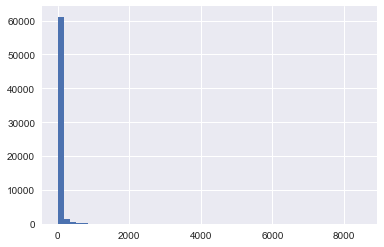

In [6]:
df_posts['score'].hist(bins = 50)

In [7]:
df_posts[df_posts['score']<1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5753 entries, 0 to 63550
Data columns (total 7 columns):
_id               5753 non-null object
date              5753 non-null datetime64[ns]
score             5753 non-null int64
second_comment    4522 non-null object
text              5753 non-null object
title             5753 non-null object
top_comment       5406 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 359.6+ KB


In [8]:
df_posts = df_posts.drop(df_posts[df_posts['score']<1].index)

In [9]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57849 entries, 3 to 63601
Data columns (total 7 columns):
_id               57849 non-null object
date              57849 non-null datetime64[ns]
score             57849 non-null int64
second_comment    52607 non-null object
text              57849 non-null object
title             57849 non-null object
top_comment       56853 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.5+ MB


In [10]:
df_posts['question'] = df_posts['title'] + ' ' + df_posts['text']

In [11]:
df_posts=df_posts.drop(['title','text', '_id'], 1)

In [12]:
df_posts

,date,score,second_comment,top_comment,question
3,2017-08-14 02:07:31,2,Guinness is a traditional one. But most darks ...,A dark beer you like to drink because you'll h...,What are good beers for a beef stew? I've hear...
4,2017-08-14 01:16:19,1,I love mashed potatoes with chili on top. It's...,Grilled cheese,What are some of your favorite comfort foods t...
5,2017-08-14 01:13:35,10,"It's probably cooked. If it's raw, it will hav...","If it's white and flaky, it's cooked. If it's ...",Is my crab meat cooked? I just got back from v...
6,2017-08-14 00:13:56,4,Heat too low on cooking oil?,Salt the eggplant first. Slice it up and sprin...,Fried eggplant help I'm Italian and my mom alw...
7,2017-08-13 22:53:34,25,Tarragon?,"Yep, tarragon\n",What is this herb? [I made this more than a fe...
8,2017-08-13 22:48:13,17,"Even when vanilla isn't accompanied by sugar, ...","yep. you could try to mask it, but honestly no...",Vanilla yogurt in chicken tandoori I'm in the ...
9,2017-08-13 22:10:51,4,I've tried both and there's not a huge differe...,could you explain both methods? never really h...,Alton Browns steamed vs Kenji's baking soda ov...
10,2017-08-13 21:56:33,2,I've found that the pregrated cheese tends to ...,Most of the time when a cheese sauce gets grit...,Gritty cheese sauce 2tbsp butter\n\n2tbsp flou...
12,2017-08-13 20:59:15,30,Looks like you have a pretty comprehensive non...,https://whatscookingamerica.net/alcoholsub.htm,What are non-alcoholic substitutes for alcohol...
13,2017-08-13 20:42:36,23,Only thing I can think of is the lime? Have yo...,Do you immediately refrigerate the salsa? If l...,Why does my salsa taste pickle-y I've been rea...


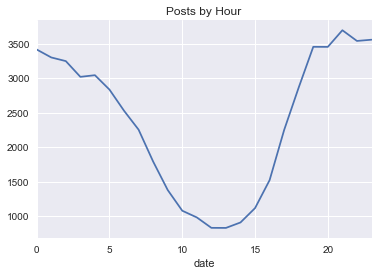

In [13]:
counts = df_posts.groupby(df_posts.date.dt.hour)['top_comment'].count()
counts.plot(x='hour', y='posts',  title = 'Posts by Hour')

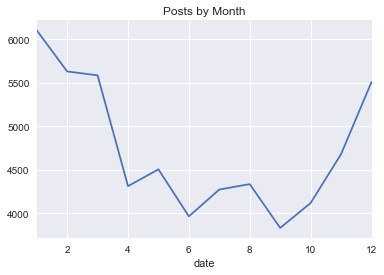

In [14]:
month = df_posts.groupby(df_posts.date.dt.month)['top_comment'].count()
month.plot(x='Month', y='Posts',  title = 'Posts by Month')

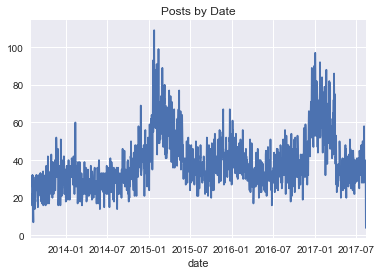

In [15]:
month = df_posts.groupby(df_posts.date.dt.date)['top_comment'].count()
month.plot(x='date', y='posts',  title = 'Posts by Date')

In [16]:
df_posts['log_score'] = df_posts['score'].apply(lambda x: np.log(x))

In [17]:
df_posts['log_score'].describe()

count    57849.000000
mean         2.318965
std          1.558411
min          0.000000
25%          1.098612
50%          2.302585
75%          3.433987
max          9.047586
Name: log_score, dtype: float64

In [18]:
df_posts = df_posts.drop(df_posts[df_posts['score']<5].index)

In [19]:
df_posts = df_posts.reset_index()

In [20]:
df_posts.head(10)

,index,date,score,second_comment,top_comment,question,log_score
0,5,2017-08-14 01:13:35,10,"It's probably cooked. If it's raw, it will hav...","If it's white and flaky, it's cooked. If it's ...",Is my crab meat cooked? I just got back from v...,2.302585
1,7,2017-08-13 22:53:34,25,Tarragon?,"Yep, tarragon\n",What is this herb? [I made this more than a fe...,3.218876
2,8,2017-08-13 22:48:13,17,"Even when vanilla isn't accompanied by sugar, ...","yep. you could try to mask it, but honestly no...",Vanilla yogurt in chicken tandoori I'm in the ...,2.833213
3,12,2017-08-13 20:59:15,30,Looks like you have a pretty comprehensive non...,https://whatscookingamerica.net/alcoholsub.htm,What are non-alcoholic substitutes for alcohol...,3.401197
4,13,2017-08-13 20:42:36,23,Only thing I can think of is the lime? Have yo...,Do you immediately refrigerate the salsa? If l...,Why does my salsa taste pickle-y I've been rea...,3.135494
5,14,2017-08-13 19:52:11,9,Less acid should yield smaller curds. How high...,I've over-drained my ricotta before and had lu...,Question about acid and milk - making ricotta ...,2.197225
6,17,2017-08-13 18:27:42,111,"Hospitality chef here, generally I don't think...","Not a chef, but own a bar with a very nice ""up...",Question for professional cooks/chefs: Do nutr...,4.709530
7,19,2017-08-13 16:47:27,245,The Food Lover's Companion is by far my favori...,[*On Food and Cooking*](https://www.amazon.com...,Where can I find descriptions of the functions...,5.501258
8,23,2017-08-13 10:20:38,85,Gewurtztraminer!,This sounds like a wonderful meal and you seem...,Cooking a multi-course dinner to thank a frien...,4.442651
9,24,2017-08-13 08:41:47,15,"It is possibly ""sugar bloom"" due to the crysta...",Looks like it's untempered. Temper the chocola...,Help - chocolate dipped marshmallow looks craz...,2.708050


In [21]:
df_posts = df_posts.dropna()

In [22]:
df_posts = df_posts.reset_index()

In [23]:
df_posts.tail()

,level_0,index,date,score,second_comment,top_comment,question,log_score
36383,38268,63589,2014-12-01 17:40:28,16,There's this too: http://amazingribs.com/tips_...,"In non-scientific terms, the liquid in the mea...","What's the point of letting meat ""rest?"" Is th...",2.772589
36384,38270,63591,2014-12-01 13:20:58,219,The only thing that matters is a thermometer. ...,"Get a thermometer, and essentially by practice...","How do I cook a perfect steak (grill, pan, or ...",5.389072
36385,38272,63594,2014-12-01 07:40:19,9,toss it to be safe. buy one that is cooked. do...,"If it's already thawed, you shouldn't refreeze...",Not sure if the turkey is safe or not So my mo...,2.197225
36386,38273,63598,2014-12-01 05:31:24,16,"I'm super cheap and still wouldn't do this, if...",Sure! Hush Puppies come from mixing the egg an...,Question about cooking the Eggs you've used fo...,2.772589
36387,38274,63600,2014-12-01 05:12:23,57,For the less tender cuts deer stroganoff. Yummy.,Venison fajitas are REALLY good. Also good way...,I brought back half a freezer's worth of deer ...,4.043051


In [24]:
df_posts = df_posts.drop(['level_0', 'index'], 1)

In [2]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', 'com', 'http', 'www', 'https', 'youtube', 'watch', 'video', 
         'imgur', 'watch', 'imgur', 'gallery', 'jpg', 'like', 'make', 'cooking', 'would', 'cook', 'recipe', 'recipes', 
         'good', 'use', 'one', 'get', 'know', 'want', 'really', 'something', 'help', 'thanks', 'need', 'anyone', 
         'looking', 'making', 'way', 'much', 'ideas', 'made', 'add', 'also', 'could', 'using', 'food', 'go',
         'things', 'got', 'going', 'think', 'people', 'lot', 'work', 'day', 'well', 'try', 'find', 
         'put', 'even', 'edit', 'anything']

In [3]:
n_components = 25
n_features = 1500
n_top_words = 10

In [27]:
tfvtrim = TfidfVectorizer(stop_words=stop, ngram_range=(1,2), min_df = 2, max_df = .95, strip_accents = 'ascii')
tfvtrim.fit(df_posts['question'])
tfvectorstrim = tfvtrim.transform(df_posts['question'])

In [28]:
nmftrim = NMF(n_components=n_components, alpha=.1, l1_ratio=.5).fit(tfvectorstrim)
print_top_words(nmftrim, tfvtrim.get_feature_names(), n_top_words)


Topic #0: time first salt water best little used ingredients butter suggestions
Topic #1: chicken breast breasts chicken breast fried chicken chicken breasts fried stock thighs chicken stock
Topic #2: iron cast cast iron skillet iron skillet iron pan seasoning skillets lodge seasoned
Topic #3: rice rice cooker fried rice cooker brown rice fried white rice water white brown
Topic #4: pork pulled pork pulled belly pork belly shoulder pork shoulder chops pork chops fat
Topic #5: oil olive olive oil garlic frying canola oils deep vegetable oil salt
Topic #6: cream ice ice cream heavy heavy cream whipped whipped cream chocolate cream maker maker
Topic #7: sauce tomato tomato sauce soy soy sauce hot sauce hot tomatoes garlic sauces
Topic #8: pizza dough pizza dough bread flour stone yeast crust pizza stone homemade pizza
Topic #9: beef ground ground beef stew beef stew corned roast corned beef cut wellington
Topic #10: cheese mac mac cheese cheese sauce cheddar cream cheese macaroni cheeses 

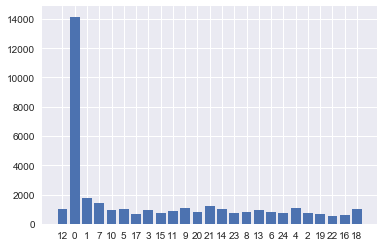

In [29]:
topic_count = get_counts(nmftrim.transform(tfvectorstrim))

plt.bar(range(len(topic_count)), topic_count.values(), align='center')
plt.xticks(range(len(topic_count)), topic_count.keys())

plt.show() 

In [30]:
topics = nmftrim.transform(tfvectorstrim)
topicslist = []
for x in topics:
    topicslist.append(get_top_topic(x))
df_posts['topic'] = topicslist

df_posts['topic'].describe()

count    36388.000000
mean         7.047900
std          7.826262
min          0.000000
25%          0.000000
50%          4.000000
75%         13.000000
max         24.000000
Name: topic, dtype: float64

Should I do subcategories? Nah; not enough spread of the other topics

Topic #0: time kitchen best ingredients first love eat suggestions new dish
Topic #1: butter peanut peanut butter unsalted salted unsalted butter salted butter cookies peanuts clarified
Topic #2: chocolate cake cookies chocolate cake chocolate chip chip mousse cocoa white chocolate cookie
Topic #3: baking bread soda flour powder baking soda baking powder sugar cup banana
Topic #4: favorite favorite cookbook favorite thing cookbook favorite year share favorite shows favorite easy favorite ways love



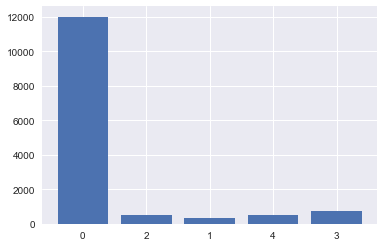

In [31]:
tft0 = tfvtrim.transform(df_posts[df_posts['topic'] == 0]['question'])
nmftrim0 = NMF(n_components=5, alpha=.1, l1_ratio=.5).fit(tft0)
print_top_words(nmftrim0, tfvtrim.get_feature_names(), n_top_words)

topic0_count = get_counts(nmftrim0.transform(tft0))

plt.bar(range(len(topic0_count)), topic0_count.values(), align='center')
plt.xticks(range(len(topic0_count)), topic0_count.keys())

plt.show() 

In [32]:
df_posts.head()

,date,score,second_comment,top_comment,question,log_score,topic
0,2017-08-14 01:13:35,10,"It's probably cooked. If it's raw, it will hav...","If it's white and flaky, it's cooked. If it's ...",Is my crab meat cooked? I just got back from v...,2.302585,12
1,2017-08-13 22:53:34,25,Tarragon?,"Yep, tarragon\n",What is this herb? [I made this more than a fe...,3.218876,0
2,2017-08-13 22:48:13,17,"Even when vanilla isn't accompanied by sugar, ...","yep. you could try to mask it, but honestly no...",Vanilla yogurt in chicken tandoori I'm in the ...,2.833213,1
3,2017-08-13 20:59:15,30,Looks like you have a pretty comprehensive non...,https://whatscookingamerica.net/alcoholsub.htm,What are non-alcoholic substitutes for alcohol...,3.401197,7
4,2017-08-13 20:42:36,23,Only thing I can think of is the lime? Have yo...,Do you immediately refrigerate the salsa? If l...,Why does my salsa taste pickle-y I've been rea...,3.135494,0


Testing things out

In [33]:
text = """how do i make the best guacamole?"""




In [36]:
df_123 = get_predict_df(text)



In [37]:
null_responses = ["Sorry I have no clue, I'm dumb", "Ask again later", "Malfunctioning. Malfunctioning"]



In [49]:
if df_123.iloc[0]['similarity'] == 0:
    print(random.randint(len(null_responses)))
else:
    a = ' '.join(df_123.iloc[0][['top_comment', 'second_comment']])

    summary = summarize(a, 3)
    for s in summary:
        print(str(s))


I find Alton Brown's recipe is always a crowd pleaser!
http://www.foodnetwork.com/recipes/alton-brown/guacamole-recipe.html http://www.seriouseats.com/2012/01/the-food-lab-the-best-guacamole-avocados-science-browning-ripening.html
http://www.seriouseats.com/recipes/2012/01/the-best-basic-guacamole-recipe.html


In [40]:
if df_123.iloc[0]['similarity'] == 0:
    print(random.randint(len(null_responses)))
else:
    b = ' '.join(df_123.iloc[1][['top_comment', 'second_comment']])

    summary = summarize(b, 5)
    for s in summary:
        print(s)

When storing leftover guacamole, put it in a glass bowl, and spread evenly in the bowl so that the entire guac surface is flat.
Then, lightly spritz the top of your guac with FRESH SQUEEZED lime juice.
Finally, put your fist inside a large piece of plastic wrap, then put your fist gently in the center of your glass bowl, and evenly spread out the plastic wrap from center out to edges, doing your best to force out any and all air pockets from between the guac and the plastic wrap.
The idea is to have direct contact between the plastic wrap and the guac on the entire surface of the guac.
squeeze lemon or lime on top of your guac and then press down some cling wrap on top of it.


In [41]:
if df_123.iloc[0]['similarity'] == 0:
    print(random.randint(len(null_responses)))
else:
    c = ' '.join(df_123.iloc[2][['top_comment', 'second_comment']])

    summary = summarize(c, 5)
    for s in summary:
        print(s)

[deleted] Add cumin, don't undersalt.


Let's see if we can predict score based on subcategory and hour/day of week for the question. Pulling in a DF that I made in my visualization notebook already coded with subcategories

In [4]:
df_sub = pd.read_pickle('df_subcats')

In [24]:
df_sub.head()

,date,score,second_comment,top_comment,question,log_score,topic,subcategory
1,2017-08-13 22:53:34,25,Tarragon?,"Yep, tarragon\n",What is this herb? [I made this more than a fe...,3.218876,0,0
4,2017-08-13 20:42:36,23,Only thing I can think of is the lime? Have yo...,Do you immediately refrigerate the salsa? If l...,Why does my salsa taste pickle-y I've been rea...,3.135494,0,0
6,2017-08-13 18:27:42,111,"Hospitality chef here, generally I don't think...","Not a chef, but own a bar with a very nice ""up...",Question for professional cooks/chefs: Do nutr...,4.709530,0,3
9,2017-08-13 08:41:47,15,"It is possibly ""sugar bloom"" due to the crysta...",Looks like it's untempered. Temper the chocola...,Help - chocolate dipped marshmallow looks craz...,2.708050,0,2
19,2017-08-12 23:56:02,5,Look up Mexican street corn dip recipes. Great...,Corn chowder. Slice the corn off of the cob an...,Recipes to use up a lot of corn on the cob/swe...,1.609438,0,3


In [5]:
df_sub = df_sub.drop(['date', 'second_comment', 'top_comment'], 1)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
tf = TfidfVectorizer(stop_words=stop, ngram_range=(1,2), min_df = 2, max_df = .95, strip_accents = 'ascii')

In [8]:
df_sub0 = df_sub[df_sub['topic']==0].reset_index()

In [9]:
tf0 = tf.fit(df_sub0['question'])

In [10]:
tfv0 = pd.DataFrame(tf0.transform(df_sub0['question']).toarray(), columns = tf0.get_feature_names())

In [11]:
lr = LinearRegression()

In [ ]:
lr.fit(tfv0, df_sub0['log_score'])

In [ ]:
lr.score()